In [141]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import statistics
import numpy as np

# Download and Load Data

In [150]:
# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
#temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
temp_dir = "/home/azureuser/cloudfiles/code/Users/lab164/recommenders/data"
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [151]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [154]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(training_large_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

['behaviors.tsv',
 'entity_embedding.vec',
 'filtered_data',
 'https_mind201910small.blob.core.windows.net_release_MINDlarge_dev.zip',
 'https_mind201910small.blob.core.windows.net_release_MINDlarge_train.zip',
 'news.tsv',
 'relation_embedding.vec',
 'train',
 'utils',
 'valid',
 '__placeholder__']

In [152]:
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_large_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

### Behaviours EDA

In [184]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).


temp_dir="/home/azureuser/cloudfiles/code/Users/lab164/recommenders/data/train"
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')

raw_behaviour=pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

raw_behaviour.head()


,impression_id,user_id,time,history,impressions
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1


In [185]:
print(f"The dataset consist of {len(raw_behaviour)} number of interactions.")

## Indexize users
unique_userIds = raw_behaviour['user_id'].unique()
# Allocate a unique index for each user, but let the zeroth index be a UNK index:
ind2user = {idx +1: item_id for idx, item_id in enumerate(unique_userIds)}
user2ind = {itemid : idx for idx, itemid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")

# Create a new column with userIdx:
#raw_behaviour['userIdx'] = raw_behaviour['user_id'].map(lambda x: user2ind.get(x,0))

The dataset consist of 22034 number of interactions.
We have 5000 unique users in the dataset


### Load Validation Behavior data

In [186]:
temp_dir_val="/home/azureuser/cloudfiles/code/Users/lab164/recommenders/data/valid"
behaviors_path = os.path.join(temp_dir_val, 'behaviors.tsv')

raw_behaviour_val=pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

#raw_behaviour.head()


print(f"The dataset consist of {len(raw_behaviour)} number of interactions.")

## Indexize users
unique_userIds = raw_behaviour_val['user_id'].unique()
# Allocate a unique index for each user, but let the zeroth index be a UNK index:
ind2user = {idx +1: item_id for idx, item_id in enumerate(unique_userIds)}
user2ind = {itemid : idx for idx, itemid in ind2user.items()}
print(f"We have {len(user2ind)} unique users in the dataset")


The dataset consist of 22034 number of interactions.
We have 5000 unique users in the dataset


### News EDA

In [187]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

news.head()

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N3112,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://www.msn.com/en-us/lifestyle/lifestyler...,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N10399,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://www.msn.com/en-us/news/world/the-cost-...,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
2,N12103,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://www.msn.com/en-us/health/voices/i-was-...,[],"[{""Label"": ""National Basketball Association"", ..."
3,N20460,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://www.msn.com/en-us/health/medical/how-t...,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."
4,N5409,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...,https://www.msn.com/en-us/weather/weathertopst...,"[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W...","[{""Label"": ""Orlando, Florida"", ""Type"": ""G"", ""W..."


In [188]:
# Build index of items
ind2item = {idx +1: itemid for idx, itemid in enumerate(news['id'].values)}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}

### Create indexed list of click history

In [189]:
# Indexize click history field
def process_click_history(s):
    list_of_strings = str(s).split(" ")
    return [item2ind.get(l, 0) for l in list_of_strings]
        
raw_behaviour['click_history_idx'] = raw_behaviour.history.map(lambda s: process_click_history(s))
raw_behaviour.head()

,impression_id,user_id,time,history,impressions,click_history_idx
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...,"[1545, 14516, 5889, 7949, 8467, 12602]"
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...,"[12070, 3341, 10176, 8105, 4983, 12855, 10405,..."
2,3,U11552,11/11/2019 1:03:52 PM,N2139,N18390-0 N10537-0 N23967-1,[2712]
3,4,U68381,11/11/2019 6:44:05 AM,N27420 N11621 N25416 N25457 N5124 N11751 N1175...,N15660-0 N18609-0 N2831-0 N5677-0 N19010-0 N15...,"[7224, 14516, 6733, 13479, 3202, 4411, 4411, 5..."
4,5,U52303,11/12/2019 3:11:52 AM,N1332 N12667,N15645-0 N7911-1,"[13217, 10867]"


### Entity Embeddings EDA

In [190]:
# The entity_embedding.vec file contains the 100-dimensional embeddings
# of the entities learned from the subgraph by TransE method.
# The first column is the ID of entity, and the other columns are the embedding vector values.
entity_embedding_path = os.path.join(temp_dir, 'entity_embedding.vec')
entity_embedding = pd.read_table(entity_embedding_path, header=None)
entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
entity_embedding = entity_embedding[[0,'vector']].rename(columns={0: "entity"})
entity_embedding


,entity,vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."
2,Q30,"[-0.115737, -0.179113, 0.102739, -0.112469, -0..."
3,Q60,"[-0.051036, -0.165637, 0.132802, -0.089949, -0..."
4,Q847017,"[-0.04397, -0.085714, 0.011526, 0.022439, 0.12..."
...,...,...
16755,Q278846,"[0.042413, 0.021957, 0.072414, -0.068437, 0.02..."
16756,Q54621949,"[-0.018299, -0.048378, -0.021645, -0.079743, 0..."
16757,Q42225228,"[-0.051346, -0.028947, -0.07587, 0.017512, -0...."
16758,Q54860678,"[-0.03162, -0.041283, -0.016871, 0.044251, -0...."


In [191]:
# The relation_embedding.vec file contains the 100-dimensional embeddings
# of the relations learned from the subgraph by TransE method.
# The first column is the ID of relation, and the other columns are the embedding vector values.
relation_embedding_path = os.path.join(temp_dir, 'relation_embedding.vec')
relation_embedding = pd.read_table(relation_embedding_path, header=None)
relation_embedding['vector'] = relation_embedding.iloc[:,1:101].values.tolist()
relation_embedding = relation_embedding[[0, 'vector']].rename(columns={0: "relation"})
relation_embedding

,relation,vector
0,P31,"[-0.073467, -0.132227, 0.034173, -0.032769, 0...."
1,P21,"[-0.078436, 0.108589, -0.049429, -0.131355, 0...."
2,P106,"[-0.052137, 0.052444, -0.019886, -0.152309, 0...."
3,P735,"[-0.051398, 0.056219, 0.068029, -0.137717, -0...."
4,P108,"[0.091231, 0.022526, 0.059349, -0.141853, 0.03..."
...,...,...
1086,P1897,"[-0.019021, 0.001183, -0.009602, -0.040833, -0..."
1087,P3776,"[-0.018365, 0.028526, -0.025934, 0.032296, -0...."
1088,P1194,"[-0.026819, 0.003231, -0.011298, -0.015206, 0...."
1089,P2502,"[0.003554, -0.041121, -0.010559, -0.037862, -0..."


# Create New Train, Val and Test Datasets:

In [192]:
raw_behaviour.head(2)

,impression_id,user_id,time,history,impressions,click_history_idx
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...,"[1545, 14516, 5889, 7949, 8467, 12602]"
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...,"[12070, 3341, 10176, 8105, 4983, 12855, 10405,..."


In [193]:
def process_impression(s):
    
    list_of_strings = s.split(" ")
    itemid_rel_tuple = [l.split("-") for l in list_of_strings]

    noclicks = []
    total_impressions=0
    num_clicks=0
    num_noclicks=0

    for entry in itemid_rel_tuple:
        if entry[1] =='0':
            noclicks.append(entry[0])
            num_noclicks+=1
        if entry[1] =='1':
            click = entry[0]
            num_clicks+=1
        total_impressions+=1
    return noclicks, click, total_impressions,num_clicks,num_noclicks

raw_behaviour['noclicks'], raw_behaviour['click'],raw_behaviour['num_impressions'],raw_behaviour['num_clicks'],raw_behaviour['num_noclicks'] = zip(*raw_behaviour['impressions'].map(process_impression))
# We can then indexize these two new columns:
raw_behaviour['noclicks'] = raw_behaviour['noclicks'].map(lambda list_of_strings: [item2ind.get(l, 0) for l in list_of_strings])
raw_behaviour['click'] = raw_behaviour['click'].map(lambda x: item2ind.get(x,0))

### Calculate click through rate:
raw_behaviour['ctr'] = (raw_behaviour['num_clicks']/raw_behaviour['num_impressions']).apply(lambda x: round(x, 2))

In [194]:
raw_behaviour.head(2)

,impression_id,user_id,time,history,impressions,click_history_idx,noclicks,click,num_impressions,num_clicks,num_noclicks,ctr
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...,"[1545, 14516, 5889, 7949, 8467, 12602]","[15078, 15981, 23272, 14872, 26384, 6447, 4788...",16179,87,1,86,0.01
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...,"[12070, 3341, 10176, 8105, 4983, 12855, 10405,...","[16071, 14830, 22380, 21105, 16036, 26272]",21064,7,1,6,0.14


array([[<AxesSubplot: title={'center': 'ctr'}>]], dtype=object)

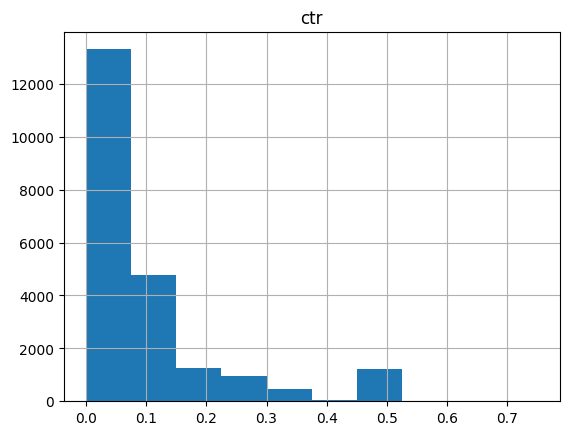

In [206]:
raw_behaviour.hist(column='ctr')

In [207]:
click_totals_list = raw_behaviour['ctr'].tolist()

print(f'The mean number of clicks is {round(statistics.mean(click_totals_list),2)}')
print(f'The median number of clicks is {statistics.median(click_totals_list)}')
print(f'The mode number of clicks is {statistics.mode(click_totals_list)}')
print(f'The standard deviation of the number of clicks is {round(statistics.stdev(click_totals_list),2)}')

The mean number of clicks is 0.1
The median number of clicks is 0.06
The mode number of clicks is 0.02
The standard deviation of the number of clicks is 0.12


### Filter Behavior Train Dataset

In [209]:
raw_behaviour_train=raw_behaviour.copy(deep=True)

In [213]:
ctr_mean = np.mean(raw_behaviour_train.ctr)
ctr_std = np.std(raw_behaviour_train.ctr)

# Filter Training Dataset:
raw_behaviour_train['ctr_std_away_mean'] = ((raw_behaviour_train.ctr - ctr_mean)/ctr_std)

#Then slice to select the rows below a threshold:
raw_behaviour_train_filtered=raw_behaviour_train[raw_behaviour_train.ctr_std_away_mean < 3]

In [214]:
raw_behaviour_train.head(2)

,impression_id,user_id,time,history,impressions,click_history_idx,noclicks,click,num_impressions,num_clicks,num_noclicks,ctr,ctr_std_away_mean
0,1,U82271,11/11/2019 3:28:58 PM,N3130 N11621 N12917 N4574 N12140 N9748,N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25...,"[1545, 14516, 5889, 7949, 8467, 12602]","[15078, 15981, 23272, 14872, 26384, 6447, 4788...",16179,87,1,86,0.01,-0.762862
1,2,U84185,11/12/2019 10:36:47 AM,N27209 N11723 N4617 N12320 N11333 N24461 N2211...,N13089-0 N18101-0 N1248-0 N26273-0 N12770-1 N1...,"[12070, 3341, 10176, 8105, 4983, 12855, 10405,...","[16071, 14830, 22380, 21105, 16036, 26272]",21064,7,1,6,0.14,0.319504


array([[<AxesSubplot: title={'center': 'ctr_std_away_mean'}>]],
      dtype=object)

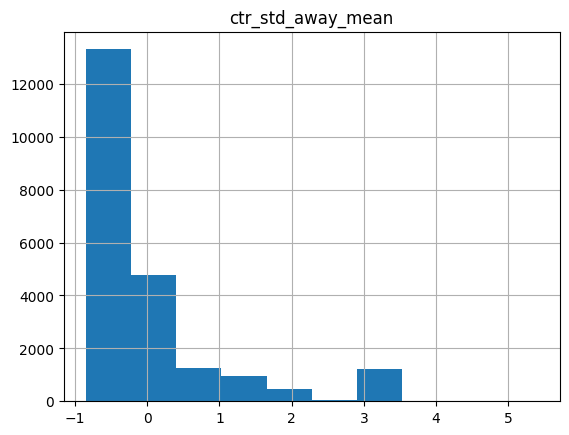

In [215]:
raw_behaviour_train.hist(column = 'ctr_std_away_mean')

In [216]:
print("Original table shape:",raw_behaviour_train.shape)
print("Filtered table shape:",raw_behaviour_train_filtered.shape)

Original table shape: (22034, 13)
Filtered table shape: (20817, 13)


# Process Validation Behaviors dataset:

In [225]:
raw_behaviour_val['noclicks'], raw_behaviour_val['click'],raw_behaviour_val['num_impressions'],raw_behaviour_val['num_clicks'],raw_behaviour_val['num_noclicks'] = zip(*raw_behaviour_val['impressions'].map(process_impression))
# We can then indexize these two new columns:
raw_behaviour_val['noclicks'] = raw_behaviour_val['noclicks'].map(lambda list_of_strings: [item2ind.get(l, 0) for l in list_of_strings])
raw_behaviour_val['click'] = raw_behaviour_val['click'].map(lambda x: item2ind.get(x,0))

### Calculate click through rate:
raw_behaviour_val['ctr'] = (raw_behaviour_val['num_clicks']/raw_behaviour_val['num_impressions']).apply(lambda x: round(x, 2))

In [226]:
raw_behaviour_val1=raw_behaviour_val.copy(deep=True)
raw_behaviour_val1.head(2)

,impression_id,user_id,time,history,impressions,noclicks,click,num_impressions,num_clicks,num_noclicks,ctr
0,1,U41827,11/15/2019 2:41:03 PM,N15366 N12202 N27489 N19773 N21134 N18191 N686...,N23699-0 N21291-0 N1901-0 N27292-0 N17443-0 N1...,"[0, 0, 0, 0, 14735, 0, 17007, 3135, 0, 0, 0, 0...",0,28,1,27,0.04
1,2,U61881,11/15/2019 10:31:42 AM,N16469 N4202 N4202 N21816 N12992 N24242 N7366 ...,N26916-0 N4641-0 N25522-0 N14893-0 N19035-0 N3...,"[0, 0, 0, 0, 16357, 19582, 0, 0, 18817, 80, 21...",0,61,1,60,0.02


In [228]:
# Filter Training Dataset:
raw_behaviour_val1['ctr_std_away_mean'] = ((raw_behaviour_val1.ctr - ctr_mean)/ctr_std)

#Then slice to select the rows below a threshold:
raw_behaviour_val_filtered=raw_behaviour_val1[raw_behaviour_val1.ctr_std_away_mean < 3]

array([[<AxesSubplot: title={'center': 'ctr_std_away_mean'}>]],
      dtype=object)

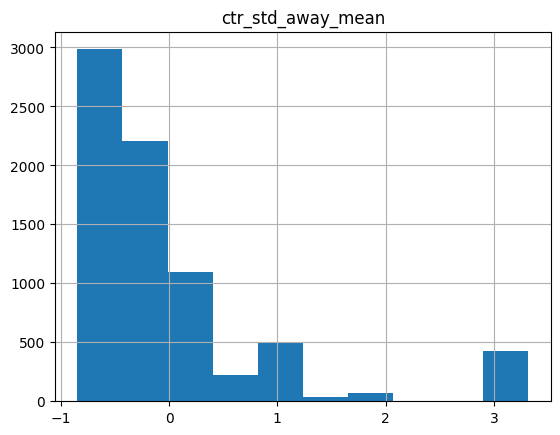

In [231]:
raw_behaviour_val1.hist(column = 'ctr_std_away_mean')

In [229]:
print("Original val table shape:",raw_behaviour_val1.shape)
print("Filtered val table shape:",raw_behaviour_val_filtered.shape)

Original val table shape: (7538, 12)
Filtered val table shape: (7116, 12)


### Save to file:

In [230]:
raw_behaviour_train_filtered.to_csv("/home/azureuser/cloudfiles/code/Users/lab164/recommenders/data/filtered_data/valid/behaviour_filtered.tsv")

raw_behaviour_val_filtered.to_csv("/home/azureuser/cloudfiles/code/Users/lab164/recommenders/data/filtered_data/valid/behaviour_filtered.tsv")